
# Experiments with PDFA Learning

The goal of the notebook is to experiment with manipulating and learning pdfa.

## Generating traces from a learning target

Here, we generate a three-state PDFA, given the following definition of a PDFA:

\textit{Probabilistic deterministic finite automaton (PDFA)}:} A PDFA is a tuple $\mathcal{A}=\left\langle Q, \Sigma, \mathbb{I}_{\mathbb{P}}, \mathbb{F}_{\mathbb{P}}, \delta_\mathbb{P}\right\rangle$ where:

\begin{itemize}
    \item $Q$ is a finite set of states; these will be labelled $q_{1}, \ldots, q_{|Q|}$ unless otherwise stated,
    \item $\Sigma$ is the alphabet,
    \item $\mathbb{I}_{\mathbb{P}}: Q \rightarrow \mathbb{Q}^{+} \cap[0,1]$ (initial-state probabilities). \textbf{For a PDFA there is a unique initial state}, i.e. $\exists q_{s} \in Q$ such that $\mathbb{I}_{\mathbb{P}}\left(q_{s}\right)=1$ and $\forall q_i \neq q_1 \in Q, \,\, \mathbb{I}_{\mathbb{P}}\left(q_{i}\right)=0$,
    \item $\mathbb{F}_{\mathbb{P}}: Q \rightarrow \mathbb{Q}^{+} \cap[0,1]$ (final-state probabilities). This can be interpreted as "the probability that you do not see any more symbols",
    \item $\delta_\mathbb{P}: Q \times \Sigma \times Q \rightarrow \mathbb{Q}^{+} \cap[0,1]$ is a transition function: the function is complete: for $a \in \Sigma$, $\delta_{\mathbb{P}}\left(q, a, q^{\prime}\right)=0$ can be interpreted as "no transition from $q$ to $q^{\prime}$ labelled with a". We will also denote $\left(q, a, q^{\prime}, P\right)$ instead of $\delta_\mathbb{P}\left(q, a, q^{\prime}\right)=P$ where $P$ is a probability. The determinism of a PDFA comes from the fact that a transition $(q, a, q' P)$ is completely defined by $q$ and $a$: 
    \begin{equation*}
    \forall q \in Q, \forall a \in \Sigma,\left|\left\{q^{\prime}: \delta_{\mathbb{P}}\left(q, a, q^{\prime}\right)>0\right\}\right| =
    \begin{cases} 
      1 & \exists \text{ a valid transition to } q' \text{under } a \\
      0 & \text{otherwise}
    \end{cases}
    \end{equation*}
\end{itemize}

$\delta_{\mathbb{P}}$ and $\mathbb{F}_{\mathbb{P}}$ are functions such that $\forall q \in Q$:

\begin{align}
\label{eqn: PDFA_final_states}
\mathbb{F}_{\mathbb{P}}(q)+\sum_{a \in \Sigma, q^{\prime} \in Q} \delta_{\mathbb{P}}\left(q, a, q^{\prime}\right)=1 \\
\therefore \mathbb{F}_{\mathbb{P}}(q) = 1 - \sum_{a \in \Sigma, q^{\prime} \in Q} \delta_{\mathbb{P}}\left(q, a, q^{\prime}\right)
\end{align}

---



[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 464 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


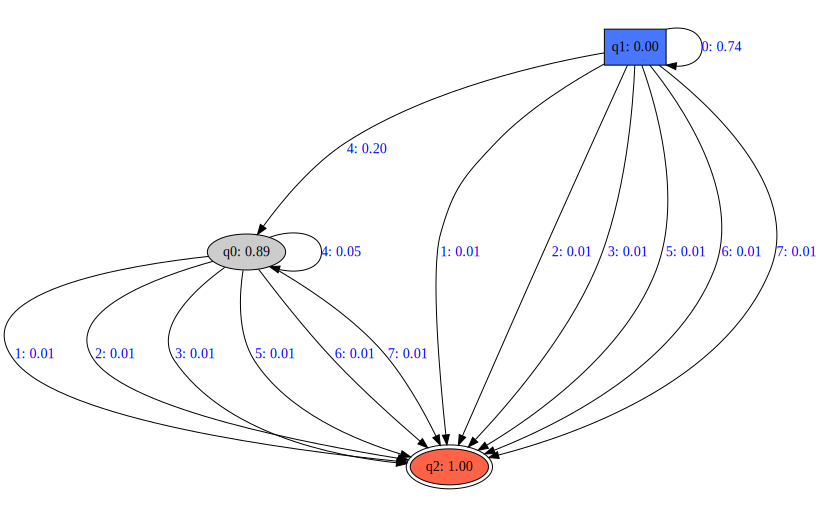

In [1]:
%load_ext autoreload
%autoreload 2
from wombats.automaton import active_automata
from sklearn.model_selection import train_test_split

config_file = 'wombats/config/pdfa_self_driving_config.yaml'
pdfa_model = active_automata.get(automaton_type='PDFA',
                                 graph_data=config_file)

num_samples = 1000
max_trace_length = 30
traces, trace_lengths = pdfa_model.generate_traces(num_samples,
                                                   N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.1
(traces_train, traces_test,
 traceLengths_train, traceLengths_test) = train_test_split(traces,
                                                           trace_lengths,
                                                           test_size=test_size)

# Write learning data to files for inference
num_traces_train = len(traces_train)
num_traces_test = len(traces_test)
pdfa_model.write_traces_to_file(traces_train, num_traces_train,
                                traceLengths_train,
                                f_name='PDFASamples_train.swag')
pdfa_model.write_traces_to_file(traces_test, num_traces_test,
                                traceLengths_test,
                                f_name='PDFASamples_test.swag')

pdfa_model.draw_IPython()

## Learning a PDFA with Flexfringe

Two choices: Using it via Python function calls, or working with the command line.

### Step 1

Install all dependencies and compile flexfringe (development branch due to some technicalities using WIFEXITED macro used for the SAT solver's process)

In [ ]:
# for the C++ code
!apt install graphviz
!apt install libgsl-dev
!apt install libpopt-dev

# for visualization and notebook interface
!pip install graphviz

# Stamina data
!wget http://stamina.chefbe.net/downloads/grid.tar.gz
!tar xfz grid.tar.gz

# cloning the repository
!rm -rf dfasat
!git clone https://bitbucket.org/chrshmmmr/dfasat.git

In [ ]:
# building the repository
# it is important to check out the development branch on colab
!cd dfasat && git checkout  && make clean all

### Step 2 
Import flexfringe tool interface

In [2]:
%autoreload 2
from wombats.learning import FlexfringeInterface

flexfringe = FlexfringeInterface()

### Step 3

Run grammatical inference using the flexfringe tool with the filename and named arguments just as described in help.

In [3]:
flexfringe.infer_model(training_file='')

no learning options specified, printing tool help:
welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

In [4]:
data = flexfringe.infer_model(training_file='PDFASamples_train.swag',
                              h='alergia',
                              d='alergia_data')

welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe -h=alergia -d=alergia_data --output-dir=./dfa PDFASamples_train.swag 
sat_program : 
valid: alergia
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic alergia
Creating apta using evaluation class alergia_data
batch mode selected
reading data finished, processing:
dfasat running x1304  x992  x736  x528  x412  m58  x408  m59  x30  m16  m20  m20  m17  m14  m10  m7  m6  x39  m5  m3  m3  x147  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  x7  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  

found intermediate solution with 11 and 11 red states
No valid 

## Analyzing Learning Results with Wombats

Here, we want to use the wombats analysis tools to characterize the learning results

### Loading Learned Flexfringe Model into Wombats

We first must get the output from flexfringe and convert it into a proper FDFA:

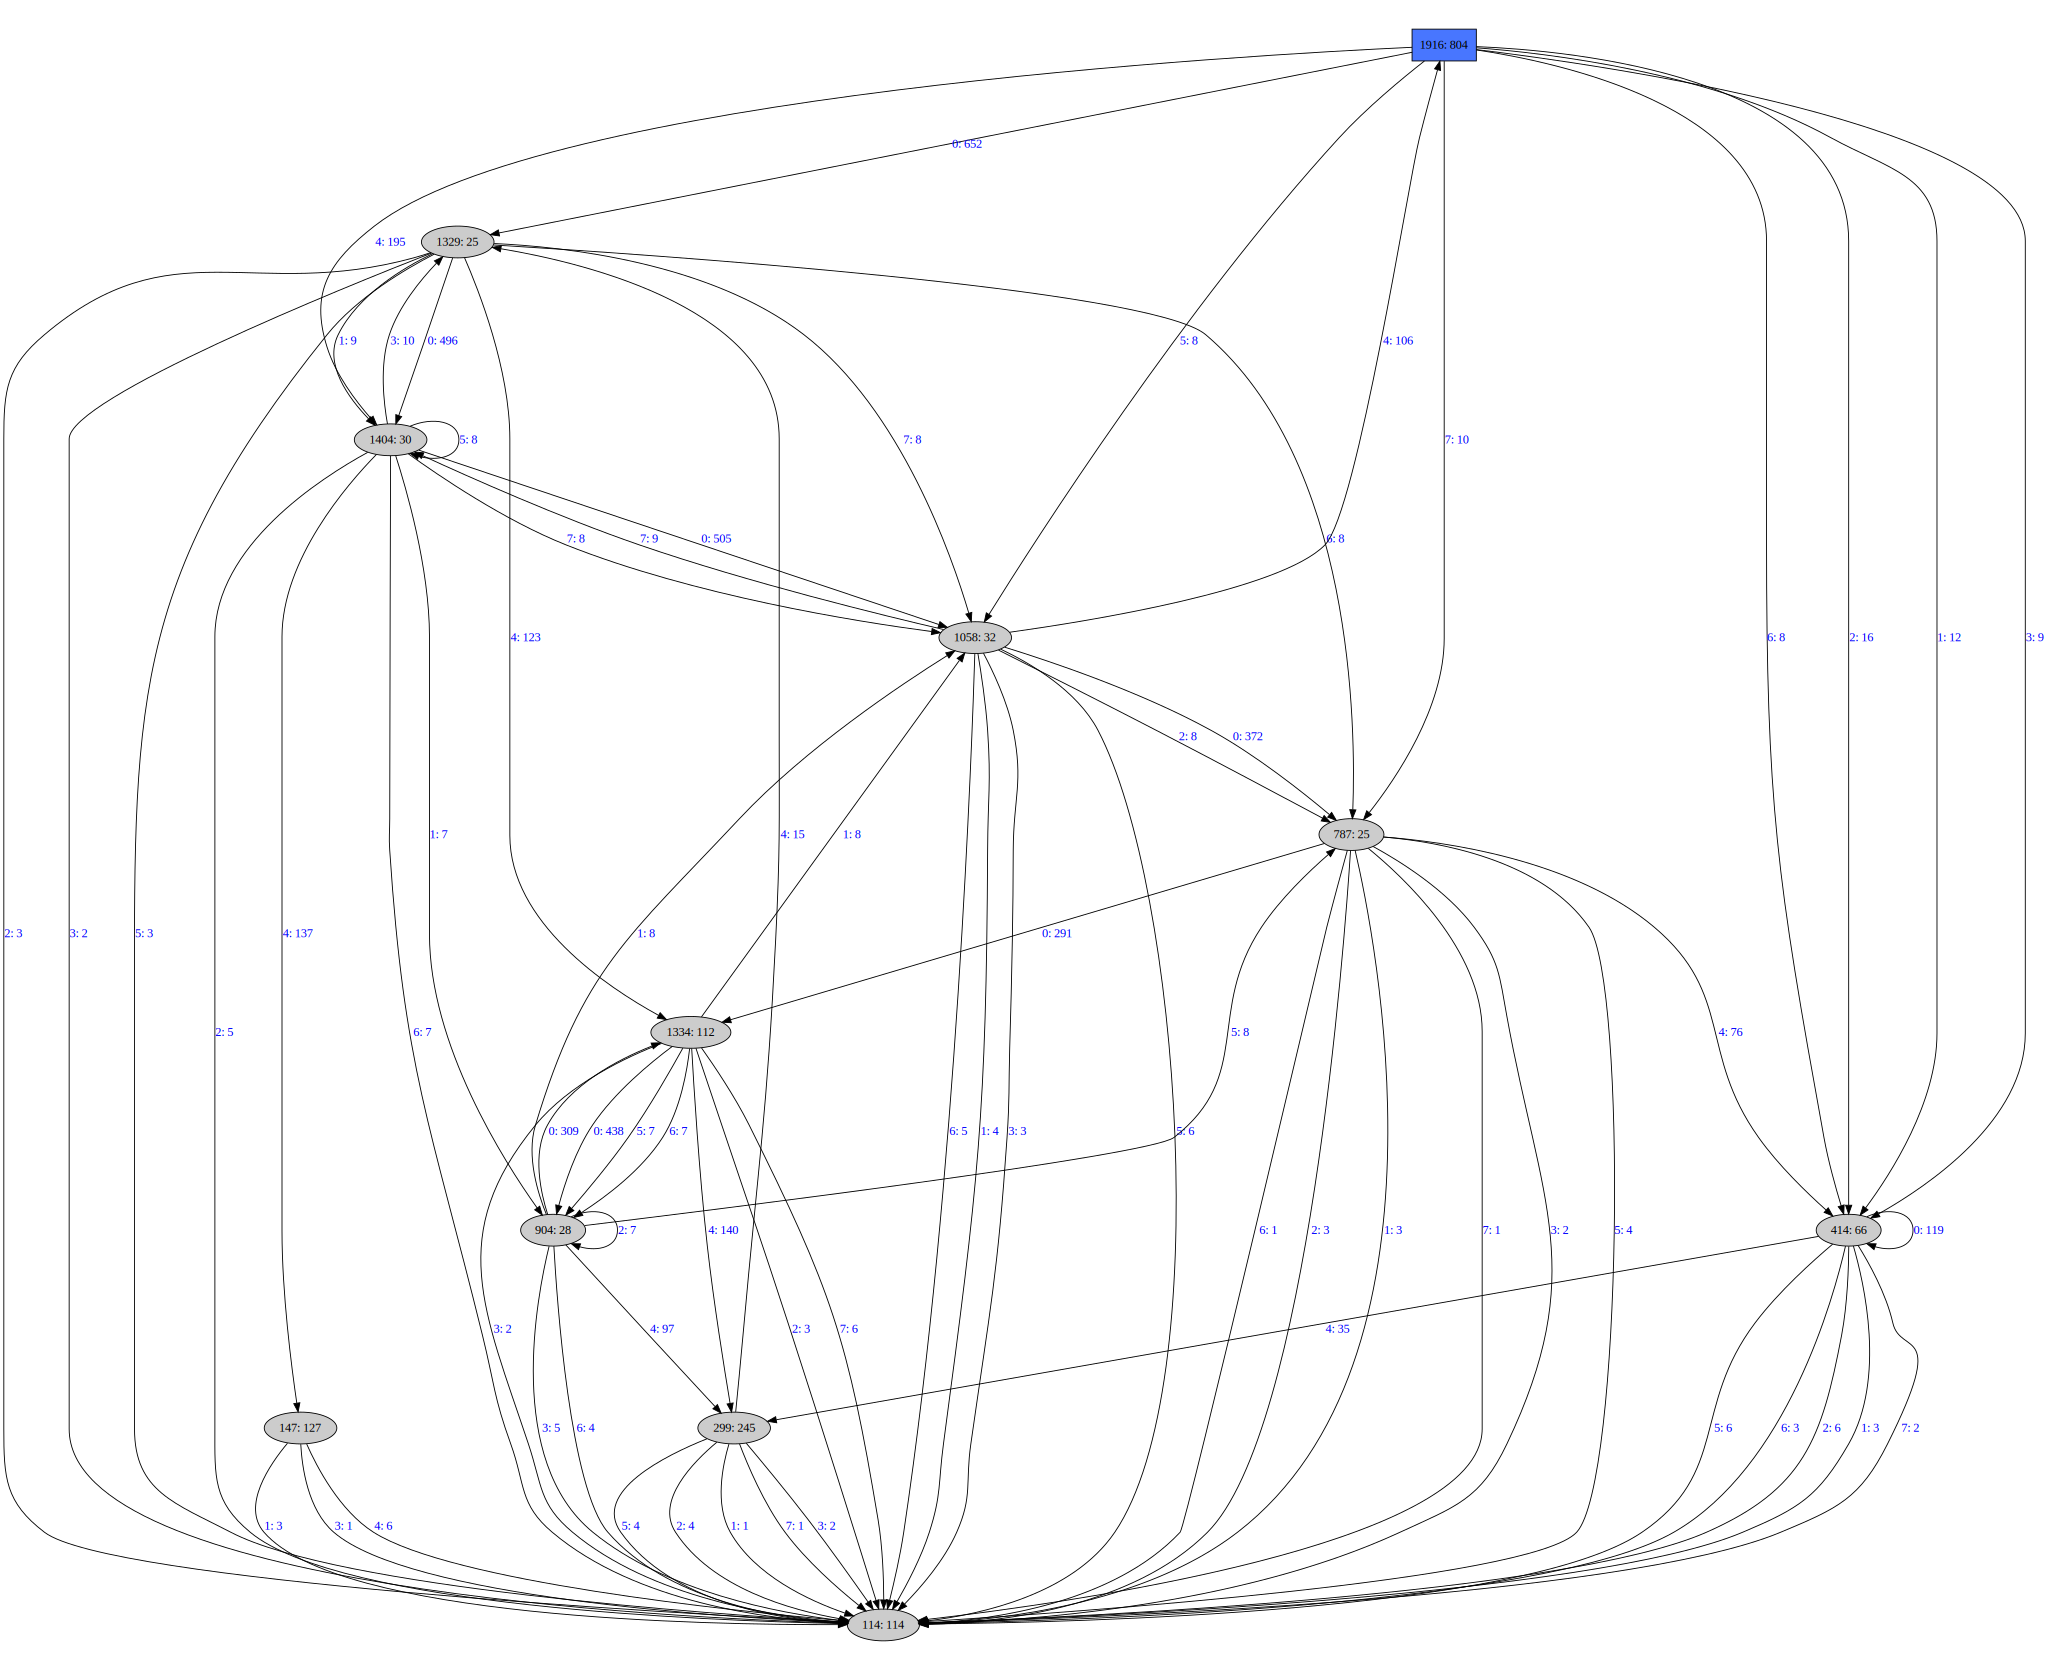

In [10]:
%autoreload 2

# learned_fdfa = active_automata.get(automaton_type='FDFA',
#                                    graph_data=data,
#                                    graph_data_format='dot_string')
# or
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe.learned_model_filepath,
                                   graph_data_format='dot_file')
learned_fdfa.draw_IPython()

With the FDFA loaded in, we use wombat conversion utilities to convert the FDFA to a PDFA (the same format as our learning target):

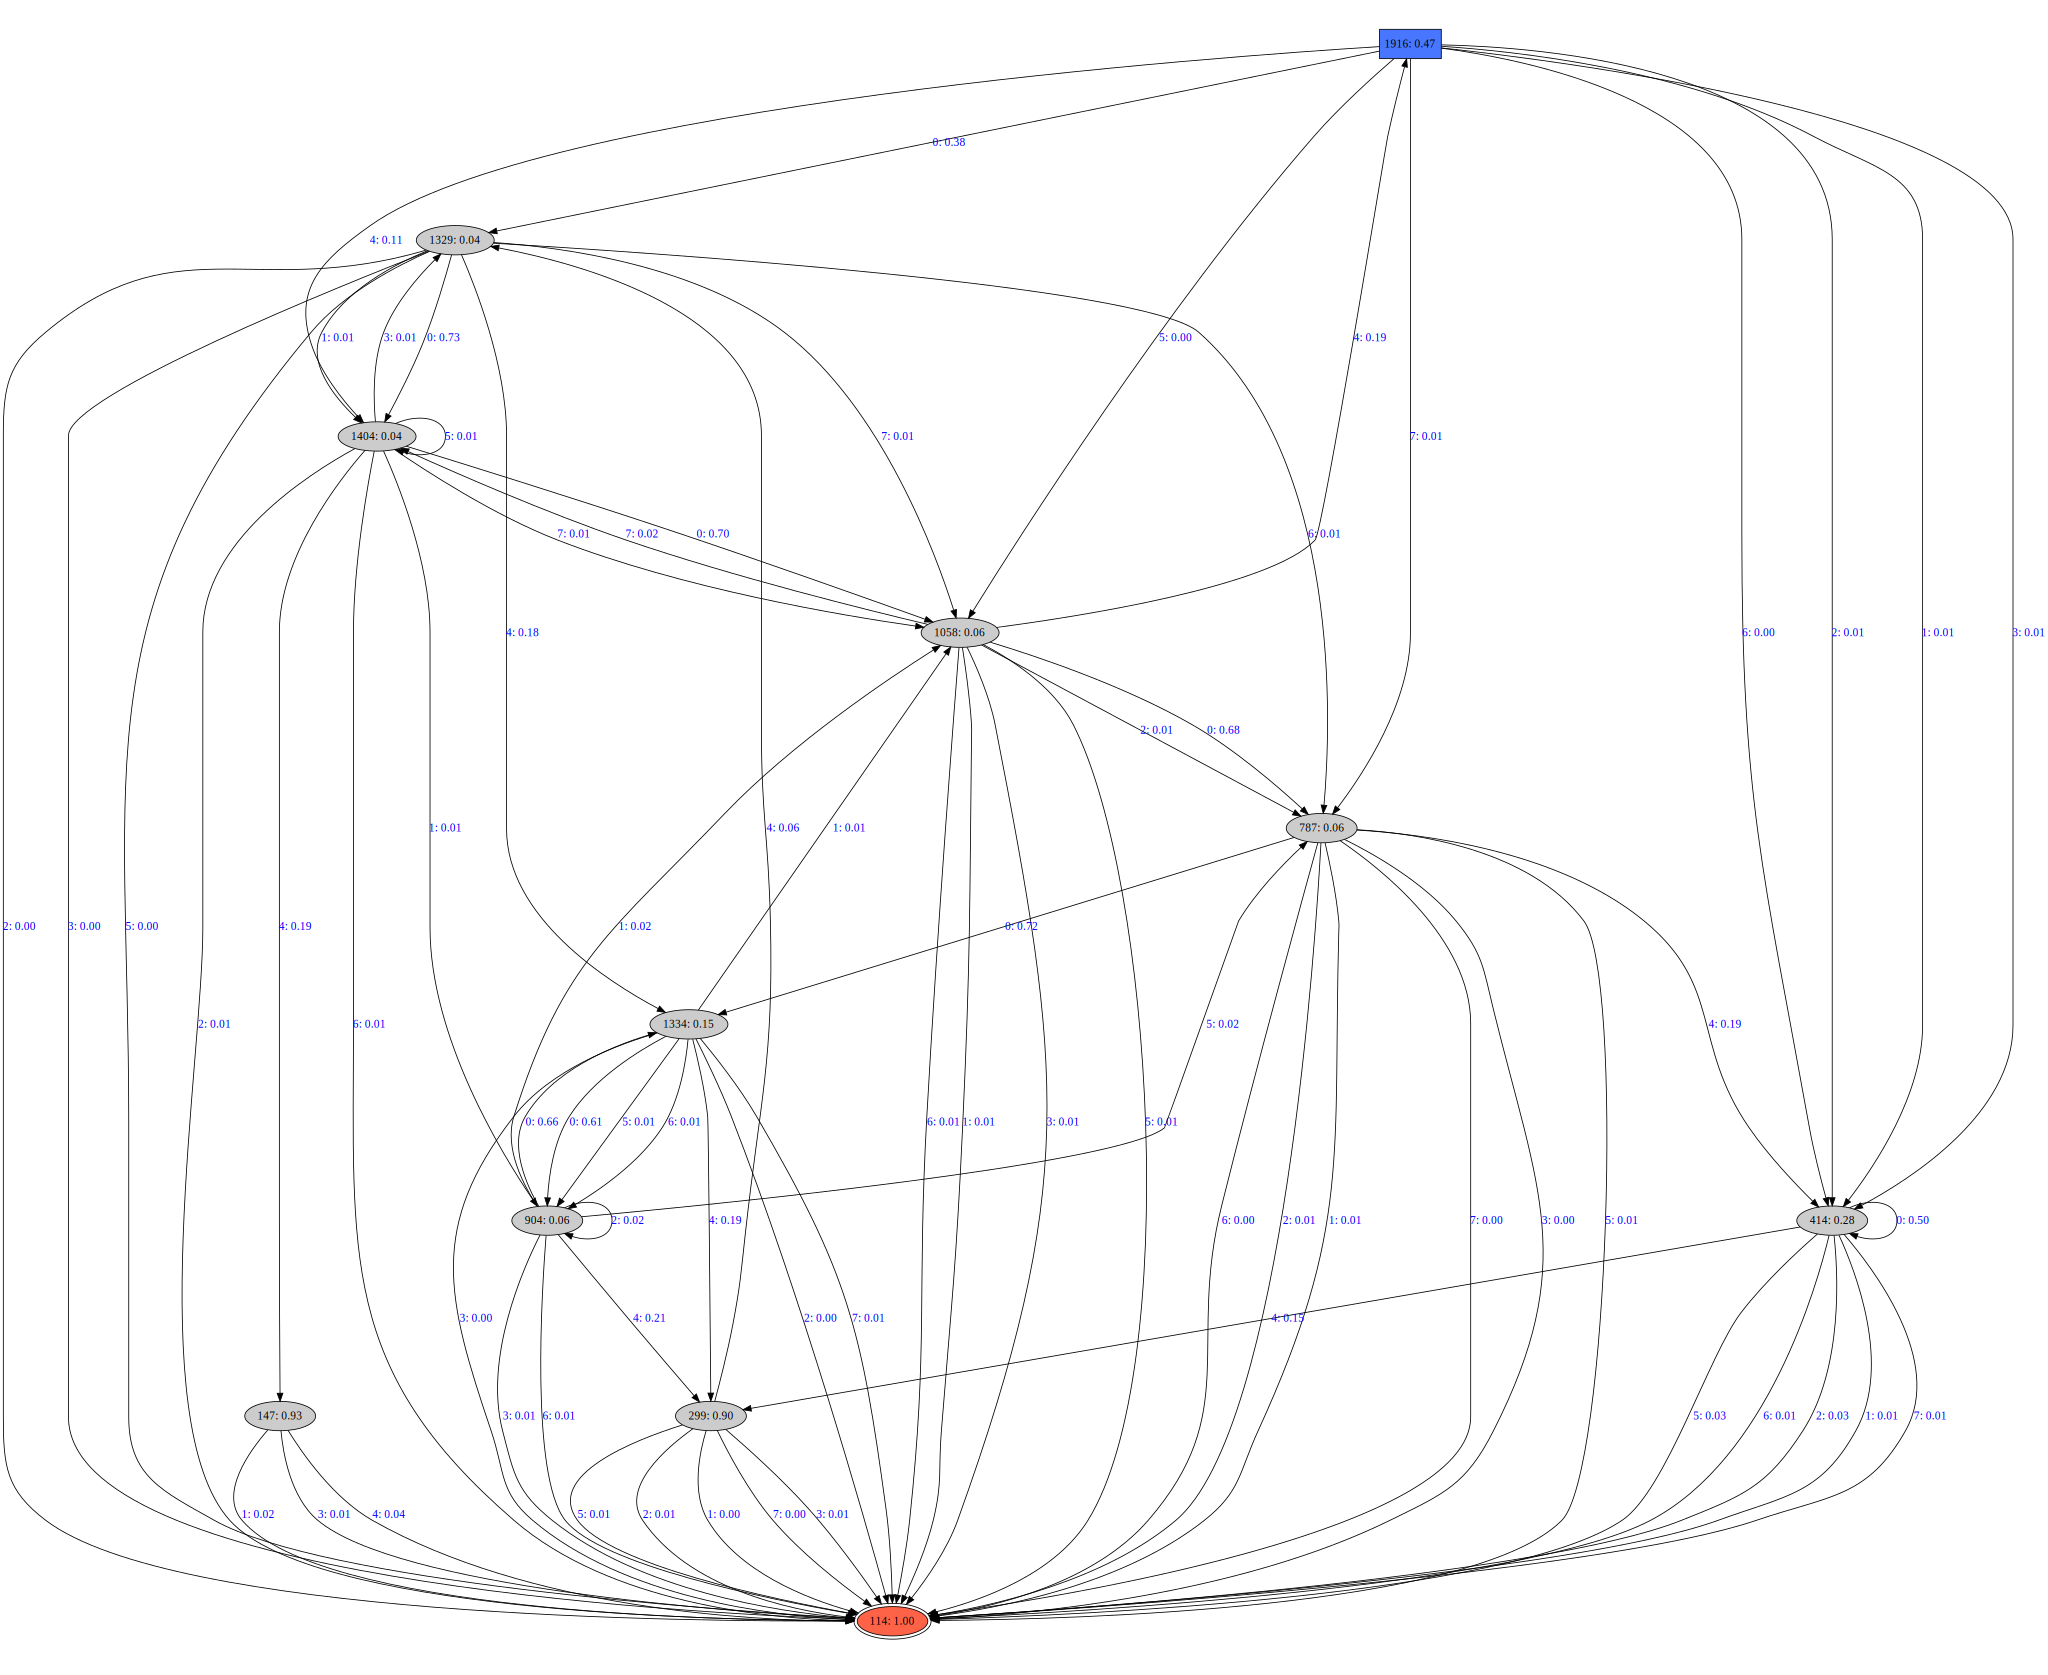

In [11]:
%autoreload 2
from wombats.automaton.pdfa import PDFA

learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object')
learned_pdfa.draw_IPython()